In [208]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
import statistics
import re
import numpy as np
import scipy, scipy.stats
from scipy.stats import binom
from scipy.stats import skewnorm
import math
from datetime import datetime
from collections import namedtuple

In [2]:
# load data as dataframe
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    # import data
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [90]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()


df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 2500) & (df1['usd_pledged'] > 25)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 2500) & (df1['usd_pledged'] > 25)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 2500)& (df1['usd_pledged'] > 25)]

df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')

# first sort by category id, then sort by date
df1.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)
df1_success.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)
df1_fail.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)


In [91]:
# write to csv file
df1.to_csv(path2 + "/All.csv", index = False) # 7722
df1_success.to_csv(path2 + "/All_Success.csv", index = False) # 5348
df1_fail.to_csv(path2 + "/All_Fail.csv", index = False)# 2374

# 7722 unique projects that were not cancelled in US with at least $25,000 goal 
# and $2500 pledged from 10/4/2009 - 12/12/2018
# 5348 unique successes
# 2374 unique failures
print(len(df1))
print(len(df1_success))
print(len(df1_fail))

74967
49106
25861


In [92]:
### CALCULATION - PROBABILITY OF SUCCESS

# probability of success per category
category_multi_projects = []
category_success_rate = {}
category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()
# creating list of categories with more than one project
for i in category_freq:
    if category_freq[i] > 1:
        category_multi_projects.append(i)
for j in category_freq:
    if j in category_success_freq.keys():
        category_success_rate[j] = category_success_freq[j] / category_freq[j]
    else: # no successes in these categories
        category_success_rate[j] = 0
    
# probability of success for aggregate categories
success_rate = len(df1_success) / len(df1)
print("Probability of success:")
print(success_rate)

Probability of success:
0.6550348820147531


In [93]:
##### CATEGORIES RESEARCH

In [234]:
### COMPETITION VS. NON-COMPETITION

df2 = df1.copy() # >1 project per category
df2_1 = df1.copy() # 1 project per category

print(1)

category_single_projects = []
for i in category_freq:
    if category_freq[i] == 1:
        category_single_projects.append(i)
df2 = df2.loc[df2['category_name'].isin(category_multi_projects)]
df2_1 = df2_1.loc[df2_1['category_name'].isin(category_single_projects)]

df3 = pd.DataFrame()
df3_1 = pd.DataFrame()
count = 0
for j in category_multi_projects:
    temp = df2.loc[df2['category_name'] == j]
    temp['overlap'] = (temp['deadline'].shift() - temp['created_at']) > timedelta(0)
    temp1 = temp.loc[temp['overlap'] == True]
    temp2 = temp.loc[temp['overlap'] == False]
    temp1.drop(['overlap'], inplace = True, axis = 1)
    temp2.drop(['overlap'], inplace = True, axis = 1)
    if len(temp1) > 0:
        df3 = df3.append(temp1) # overlapping projects within category
    if len(temp2) > 0:
        df3_1 = df3_1.append(temp2) # non-overlapping projects within category

print(1)

df3_1 = df3_1.append(df2_1) # single + non-overlapping projects
            
df3_success = df3.loc[df3['state'] == 'successful'] # successful subset for competing projects
df3_fail = df3.loc[df3['state'] == 'failed'] # failed subset for competing projects
df3_1_success = df3_1.loc[df3_1['state'] == 'successful'] # successful subset for non-competing projects
df3_1_fail = df3_1.loc[df3_1['state'] == 'failed'] # failed subset for non-competing projects

1


/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1


In [266]:
Range = namedtuple('Range', ['start', 'end'])

concurrent = []
curr_duration = []
count = 0
for j in category_multi_projects:
    temp = df3.loc[df3['category_name'] == j]
    temp.sort_values(['deadline'], ascending = [True], inplace = True)
    if j == 'technology/hardware':
        print(temp)

    lst_start = list(temp['created_at'])
    lst_end = list(temp['deadline'])

    for i in range(len(lst_start)):
        r1 = Range(start=lst_start[i], end=lst_end[i])
        count_concurrent = 1
        curr_duration.append(lst_end[i] - lst_start[i])
        for j in range(len(lst_start)):
            if i != j:
                r2 = Range(start=lst_start[j], end=lst_end[j])
                latest_start = max(r1.start, r2.start)
                earliest_end = min(r1.end, r2.end)
                delta = (earliest_end - latest_start).days + 1
                overlap = max(0, delta)
                if overlap > 0:
                    count_concurrent += 1
        concurrent.append(count_concurrent)

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


      creator_id          id  \
2423  1777025878  1820414655   
1677  1702920777   856029161   
1800   895964375   885658613   
1005  1992078142   635349146   
1059   566218294   914381605   
743   1583156960  1407093142   
252    417086015   343646776   
345   1502220831    42241807   
3412   488338692   890913932   
3132   930368578  1404597492   
1720   345598377  1030448552   
1189   688934939  1720980318   
1211  1939042787    14660709   
2045   904289150   222845515   
1318   981348905  2114610106   
1503   530263804  1781691788   
2361    86514518  1448539593   
607    788949651   687939149   
1231  1171859847   468341200   
1471   106623684  1434238176   
875   1112905993    54406707   
582     44998465  1650302841   
573   1392317236  1376879513   
2565   421256045   767595643   
2584  1431718907  1824343684   
830   1510502615  1306424800   
1739  1783494646  1381711170   
2556   340034841  1704676482   
1542  1761426769   199158008   
1094  1276765289  1007566985   
...     

Text(0, 0.5, 'Duration (months)')

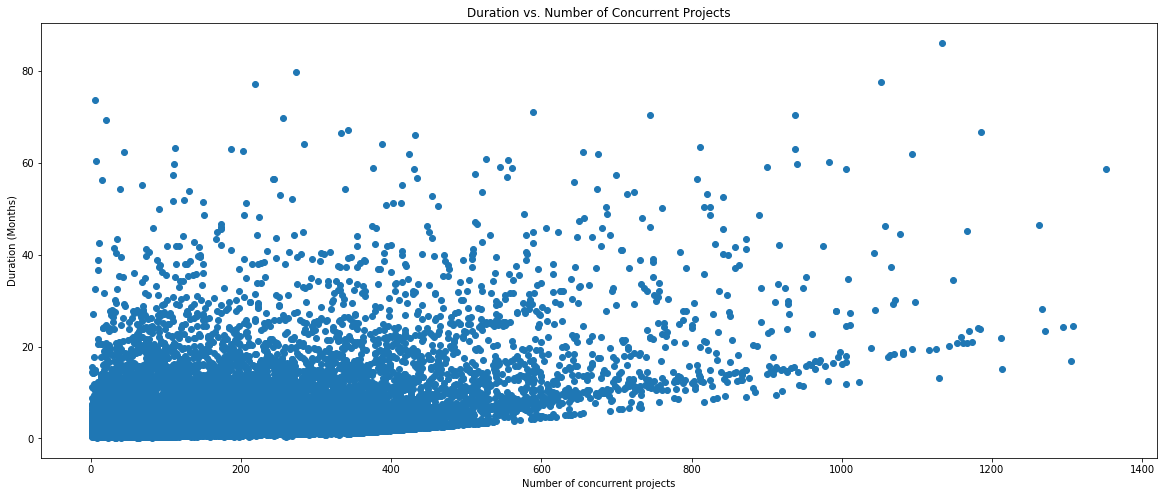

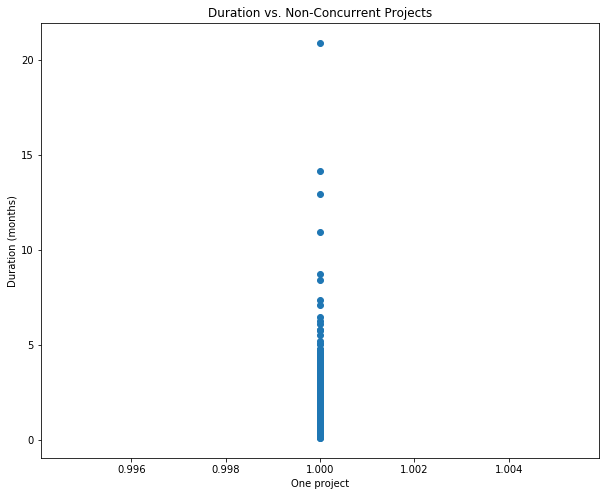

In [267]:
months = []
for i in curr_duration:
    months.append(i/ np.timedelta64(1,'M'))

fig1 = plt.figure(figsize = (20,8))
plt.scatter(concurrent, months)
plt.title('Duration vs. Number of Concurrent Projects')
plt.xlabel('Number of concurrent projects')
plt.ylabel('Duration (Months)')

months1 = []
lst_start = list(df3_1['created_at'])
lst_end = list(df3_1['deadline'])

for i in range(len(lst_start)):
    months1.append((lst_end[i] - lst_start[i])/ np.timedelta64(1,'M'))
fig2 = plt.figure(figsize = (10,8))
plt.scatter([1] * len(months1), months1)
plt.title('Duration vs. Non-Concurrent Projects')
plt.xlabel('One project')
plt.ylabel('Duration (months)')


In [97]:
# write to csv file
# projects in the same category with overlapping time series
df3.to_csv(path2 + "/All_Competition.csv", index = False) # 6615
df3_success.to_csv(path2 + "/Success_Competition.csv", index = False) # 4578
df3_fail.to_csv(path2 + "/Fail_Competition.csv", index = False) # 2037
df3_1.to_csv(path2 + "/All_Non_Competition.csv", index = False) # 1107
df3_1_success.to_csv(path2 + "/Success_Non_Competition.csv", index = False) # 770
df3_1_fail.to_csv(path2 + "/Fail_Non_Competition.csv", index = False) # 337

# 6615 projects in the same category with overlapping time series
# 4578 of these projects were successful
# 2037 of these projects failed
print(len(df3))
print(len(df3_success))
print(len(df3_fail))

# 1107 projects had no competition
# 770 of these projects were successful
# 337 of these projects failed
print(len(df3_1))
print(len(df3_1_success))
print(len(df3_1_fail))

73719
48305
25414
1248
801
447


In [98]:
df3['duration'] = (df3['deadline'] - df3['created_at']) / np.timedelta64(1,'M')

print('Average duration for all competitive projects: ')
print(np.mean(list(df3['duration'])))
print('Median duration for all competitive projects: ')
print(statistics.median(list(df3['duration'])))

df3_1['duration'] = (df3_1['deadline'] - df3_1['created_at']) / np.timedelta64(1,'M')

print('Average duration for all non_competitive projects: ')
print(np.mean(list(df3_1['duration'])))
print('Median duration for all non_competitive projects: ')
print(statistics.median(list(df3_1['duration'])))

Average duration for all competitive projects: 
2.9854135837457947
Median duration for all competitive projects: 
1.854224704591242
Average duration for all non_competitive projects: 
1.5573252378381206
Median duration for all non_competitive projects: 
1.2656743274825781


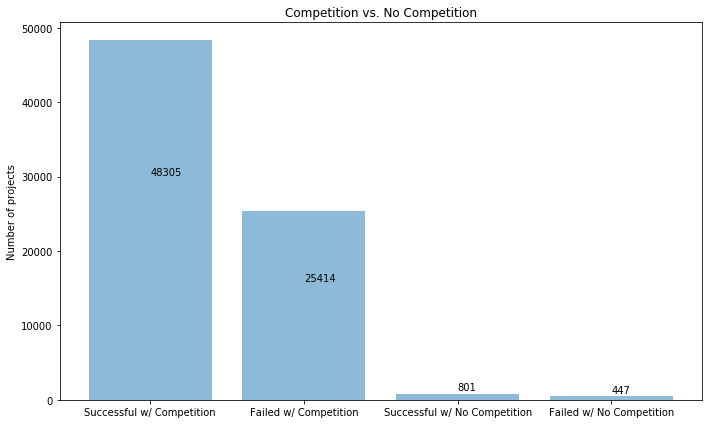

<Figure size 432x288 with 0 Axes>

In [99]:
objects = ('Successful w/ Competition', 'Failed w/ Competition', 
           'Successful w/ No Competition', 'Failed w/ No Competition')
y_pos = np.arange(len(objects))
performance = [len(df3_success), len(df3_fail), len(df3_1_success), len(df3_1_fail)]

fig = plt.figure(figsize=(10, 6))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)

# Create labels
 
# Text on the top of each barplot
plt.text(x = 0 , y = 30200, s = performance[0], size = 10)
plt.text(x = 1 , y = 16000, s = performance[1], size = 10)
plt.text(x = 2 , y = 1250, s = performance[2], size = 10)
plt.text(x = 3 , y = 900, s = performance[3], size = 10)


plt.ylabel('Number of projects')
plt.title('Competition vs. No Competition')

plt.tight_layout()

plt.show()

path3 = "../Desktop/cleaned_kickstarter_plots/"
plt.savefig(path3 + 'Competition_vs_No_Competition.png')

In [100]:
competition_category_success_rate = {}
competition_category_freq = df3['category_name'].value_counts().to_dict()
competition_category_success_freq = df3_success['category_name'].value_counts().to_dict()
competition_category_fail_freq = df3_fail['category_name'].value_counts().to_dict()

non_competition_category_success_rate = {}
non_competition_category_freq = df3_1['category_name'].value_counts().to_dict()
non_competition_category_success_freq = df3_1_success['category_name'].value_counts().to_dict()
non_competition_category_fail_freq = df3_1_fail['category_name'].value_counts().to_dict()

In [101]:
### CALCULATION - NUMBER OF PROJECTS PER CATEGORY

# all
category_num = dict()
for k, v in category_freq.items():
    category_num[k] = [v]

# all success
for k, v in category_freq.items():
    if k in category_success_freq.keys():
        category_num[k].append(category_success_freq[k])
    else: # no successes in these categories
        category_num[k].append(0)
# all fail        
for k, v in category_freq.items():
    if k in category_fail_freq.keys():
        category_num[k].append(category_fail_freq[k])
    else:
        category_num[k].append(0)

#-------------------

# competition
for k, v in category_freq.items():
    if k in competition_category_freq.keys():
        category_num[k].append(competition_category_freq[k])
    else:
        category_num[k].append(0)
        
# competition success
for k, v in category_freq.items():
    if k in competition_category_success_freq.keys():
        category_num[k].append(competition_category_success_freq[k])
    else:
        category_num[k].append(0)
        
# competition fail
for k, v in category_freq.items():
    if k in competition_category_fail_freq.keys():
        category_num[k].append(competition_category_fail_freq[k])
    else:
        category_num[k].append(0)
        
#-------------------

# non-competition
for k, v in category_freq.items():
    if k in non_competition_category_freq.keys():
        category_num[k].append(non_competition_category_freq[k])
    else:
        category_num[k].append(0)
        
# non-competition success
for k, v in category_freq.items():
    if k in non_competition_category_success_freq.keys():
        category_num[k].append(non_competition_category_success_freq[k])
    else:
        category_num[k].append(0)
        
# non-competition fail
for k, v in category_freq.items():
    if k in non_competition_category_fail_freq.keys():
        category_num[k].append(non_competition_category_fail_freq[k])
    else:
        category_num[k].append(0)

# ------------------
        
# Write calculations to csv files

df7 = pd.DataFrame(category_num.items(), columns = ['category_name', 'number'])
with open(path2 + "/Number_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Success','Fail','Competition', \
                     'Competition Success', 'Competition Fail', 'Non-Competition',\
                    'Non-Competition Success', 'Non-Competition Fail'])
    for i in range(len(df7['number'])):
        lst1 = list(df7['number'])[i]
        if lst1[3] not in ['1.0','1','0.0','0']: # > 0 competing projects
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

In [102]:
basic_categories = {}
labels = list(category_num.keys())
all_num = [ele[1] for ele in category_num.values()]

for i in range(len(labels)):
    if '/' in labels[i]:
        temp = re.findall(r'\w+:?(?=/)',labels[i])[0]
        if temp in basic_categories.keys():
            basic_categories[temp] += all_num[i]
        else:
            basic_categories[temp] = all_num[i]
    else:
        if labels[i] in basic_categories.keys():
            basic_categories[labels[i]] += all_num[i]
        else:
            basic_categories[labels[i]] = all_num[i]
            
print(basic_categories)

{'video': 11381, 'food': 7496, 'technology': 8150, 'design': 2878, 'music': 11112, 'games': 5175, 'publishing': 6816, 'art': 6095, 'comics': 3360, 'theater': 2469, 'fashion': 3780, 'dance': 1466, 'photography': 2146, 'journalism': 1290, 'crafts': 1168, 'film & video': 185}


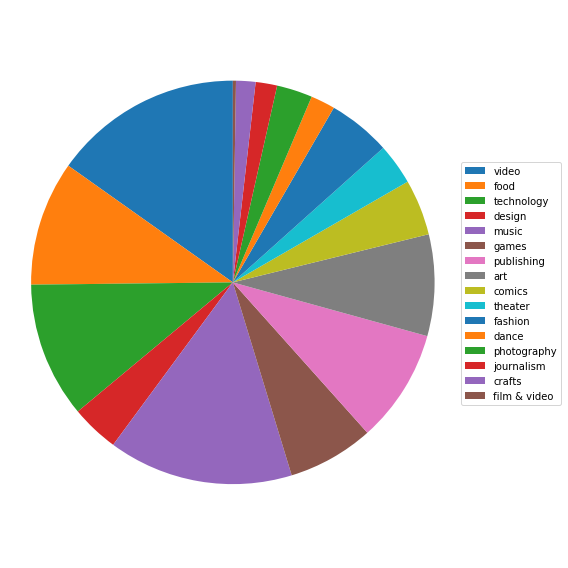

<Figure size 432x288 with 0 Axes>

In [103]:
fig = plt.figure(figsize=(8, 8))
patches, texts = plt.pie(basic_categories.values(), startangle=90)
plt.legend(patches, basic_categories.keys(), loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.savefig(path3 + 'Categories_number_of_projects.png')

In [104]:
### CALCULATION - PROPORTION PER CATEGORY

# all
category_frac = dict()
for k, v in category_freq.items():
    category_frac[k] = [v / len(df1)]

# success
for k, v in category_freq.items():
    if k in category_success_freq.keys():
        category_frac[k].append(category_success_freq[k] / len(df1_success))
    else: # no successes in these categories
        category_frac[k].append(0)
# fail        
for k, v in category_freq.items():
    if k in category_fail_freq.keys():
        category_frac[k].append(category_fail_freq[k] / len(df1_fail))
    else:
        category_frac[k].append(0)
        
#-------------------

# competition
for k, v in category_freq.items():
    if k in competition_category_freq.keys():
        category_frac[k].append(competition_category_freq[k] / len(df3))
    else:
        category_frac[k].append(0)
        
# competition success
for k, v in category_freq.items():
    if k in competition_category_success_freq.keys():
        category_frac[k].append(competition_category_success_freq[k] / len(df3_success))
    else:
        category_frac[k].append(0)
        
# competition fail
for k, v in category_freq.items():
    if k in competition_category_fail_freq.keys():
        category_frac[k].append(competition_category_fail_freq[k] / len(df3_fail))
    else:
        category_frac[k].append(0)
        
# ------------------

# non-competition
for k, v in category_freq.items():
    if k in non_competition_category_freq.keys():
        category_frac[k].append(non_competition_category_freq[k] / len(df3_1))
    else:
        category_frac[k].append(0)
        
# non-competition success
for k, v in category_freq.items():
    if k in non_competition_category_success_freq.keys():
        category_frac[k].append(non_competition_category_success_freq[k] / len(df3_1_success))
    else:
        category_frac[k].append(0)
        
# non-competition fail
for k, v in category_freq.items():
    if k in non_competition_category_fail_freq.keys():
        category_frac[k].append(non_competition_category_fail_freq[k] / len(df3_1_fail))
    else:
        category_frac[k].append(0)

# ------------------
        
# Write calculations to csv files

df8 = pd.DataFrame(category_frac.items(), columns = ['category_name', 'proportion'])
with open(path2 + "/Proportion_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Success','Fail','Competition', \
                     'Competition Success', 'Competition Fail', 'Non-Competition',\
                    'Non-Competition Success', 'Non-Competition Fail'])
    for i in range(len(df8['proportion'])):
        lst1 = list(df8['proportion'])[i]
        if lst1[3] not in ['1.0','1','0.0','0']:
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

In [105]:
### CALCULATION - PROBABILITY OF SUCCESS PER CATEGORY

# probability of success per category conditional on competition

# creating list of categories with overlapping projects
competition_category_success_rate = {}
for i in category_freq:
    if i in category_multi_projects:
        if i in competition_category_success_freq.keys():
            competition_category_success_rate[i] = competition_category_success_freq[i] / competition_category_freq[i]
        else:
            if i in competition_category_freq.keys():
                competition_category_success_rate[i] = 0
            else:
                competition_category_success_rate[i] = -1000000
    else:
        competition_category_success_rate[i] = -1000000
    
# probability of success for aggregate categories conditional on competition
competition_success_rate = len(df3_success) / len(df3)
print("Probability of success conditional on competition:")
print(competition_success_rate)
temp1 = list(competition_category_success_rate.values())
temp1 = [value for value in temp1 if value != -1000000]
print("Averaging across categories:")
print(sum(temp1) / len(temp1))
print("Median across categories:")
print(statistics.median(temp1))

# --------------

# probability of success per category conditional on no competition

for i in category_freq:
    if i in category_single_projects or i in category_multi_projects:
        if i in non_competition_category_success_freq.keys():
            non_competition_category_success_rate[i] = non_competition_category_success_freq[i] / non_competition_category_freq[i]
        else:
            if i in non_competition_category_freq.keys():
                non_competition_category_success_rate[i] = 0
            else:
                non_competition_category_success_rate[i] = -1000000
    else:
        non_competition_category_success_rate[i] = -1000000
    
non_competition_success_rate = len(df3_1_success) / len(df3_1)
print("Probability of success conditional on non-competition:")
print(non_competition_success_rate)
temp2 = list(non_competition_category_success_rate.values())
temp2 = [value for value in temp2 if value != -1000000]
print("Averaging across categories:")
print(sum(temp2) / len(temp2))
print("Median across categories:")
print(statistics.median(temp2))

# --------------

# Write calculations to csv files

subsets = [category_success_rate, competition_category_success_rate, non_competition_category_success_rate]

prob_success = {}
for k in category_success_rate.keys():
    prob_success[k] = list(str(prob_success[k]) for prob_success in subsets)

df9 = pd.DataFrame(prob_success.items(), columns = ['category_name', 'prob_of_success'])
count_compete = 0
count_non_compete = 0
with open(path2 + "/Prob_Of_Success_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Competition','Non-Competition', 'Difference'])
    lst2 = list(category_freq.keys())
    for i in range(len(df9['prob_of_success'])):
        lst = list(df9['prob_of_success'])[i]
        lst1 = [ '%.4f' % float(j) for j in lst]
        #if lst1[1] not in ['1.0000','1','0.0000','0'] and lst1[2] not in ['1.0000','1','0.0000','0']: # > 0 competing/non-competing projects
        lst1.insert(0, str(lst2[i]))
        diff = round(float(lst1[2]) - float(lst1[3]),4)
        lst1.insert(len(lst1),str(diff))
        if diff > 0 and abs(diff) <= 1:
            count_compete += 1
        elif abs(diff) <= 1:
            count_non_compete += 1
        writer.writerow(lst1)

print("Prob of success competition > non-competition for the following percentage of categories: ")
print("{:.2%}".format(count_compete / (count_compete + count_non_compete)))

# Overall probability of success:
# 0.6925666925666926

# 21.71% same prob of success
# 52.71% non-comp better
# 25.58% comp better

Probability of success conditional on competition:
0.6552584815312199
Averaging across categories:
0.545649424948324
Median across categories:
0.49603672113177816
Probability of success conditional on non-competition:
0.6418269230769231
Averaging across categories:
0.6984775569791234
Median across categories:
0.75
Prob of success competition > non-competition for the following percentage of categories: 
17.86%


In [106]:
def mean_confidence_interval(data, confidence):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

s = 48305
n = 73719
p = 0.6552584815312199
s = 801
n = 1248
p = 0.6418269230769231


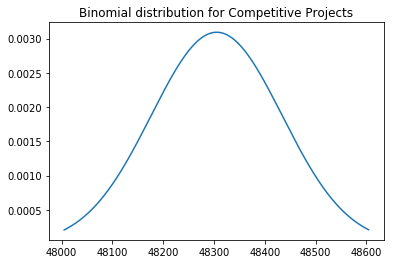

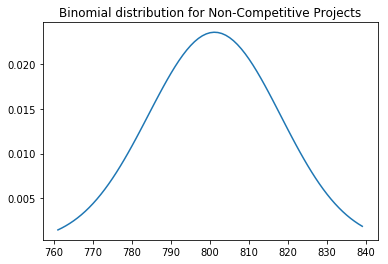

In [107]:
temp3 = []
for i in range(len(df3)):
    if i < len(df3_success):
        temp3.append(1)
    else:
        temp3.append(0)
temp4 = []
for i in range(len(df3_1)):
    if i < len(df3_1_success):
        temp4.append(1)
    else:
        temp4.append(0)
        
s1, n1, p1 = temp3.count(1), len(temp3), np.mean(temp3)
mean1, var1, skew1, kurt1 = binom.stats(n1, p1, moments = 'mvsk')

x1 = np.arange(binom.ppf(0.01, n1, p1), binom.ppf(0.99, n1, p1))

plt.plot(x1, binom.pmf(x1, n1, p1))
plt.title('Binomial distribution for Competitive Projects')
print('s = ' + str(s1))
print('n = ' + str(n1))
print('p = ' + str(p1))

s2, n2, p2 = temp4.count(1), len(temp4), np.mean(temp4)
mean2, var2, skew2, kurt2 = binom.stats(n2, p2, moments = 'mvsk')

x2 = np.arange(binom.ppf(0.01, n2, p2), binom.ppf(0.99, n2, p2))

plt.figure()
plt.plot(x2, binom.pmf(x2, n2, p2))
plt.title('Binomial distribution for Non-Competitive Projects')
print('s = ' + str(s2))
print('n = ' + str(n2))
print('p = ' + str(p2))

In [108]:
# test if two binomial distributions are statistically different
# H0: p1 = p2
# HA: p1 != p2
p = (s1 + s2) / (n1 + n2)
z = (p1 - p2) / (p * (1 - p) * ((1 / n1) + (1 / n2))) ** (0.5)

z_95 = scipy.stats.norm.ppf(0.975)
print(z)
print(z_95)
if z > z_95:
    print('Reject H0: Statistically different')
else:
    print('Accept H0')

0.9898480818497787
1.959963984540054
Accept H0


All competitive vs. non-competitive projects goal confidence interval
(35271.78332953512, 29941.452587055886, 40602.11407201436)
(33733.252668269226, 14790.153571137645, 52676.3517654008)
(14826.113669806437, 14481.003428006634, 15171.22391160624)
(14598.024132334582, 12824.011874529835, 16372.036390139328)
(74133.35856024238, 58696.060240036226, 89570.65688044854)
(68022.5548098434, 15249.699182192351, 120795.41043749443)


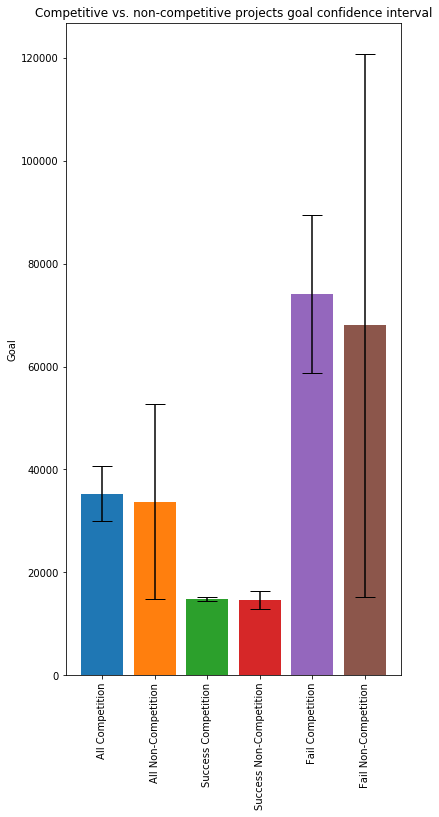

In [109]:
print('All competitive vs. non-competitive projects goal confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df3['goal']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df3_1['goal']), 0.95)

x5, x4, x6 = mean_confidence_interval(list(df3_success['goal']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df3_1_success['goal']), 0.95)

x8, x7, x9 = mean_confidence_interval(list(df3_fail['goal']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df3_1_fail['goal']), 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects goal confidence interval')
plt.ylabel('Goal')
plt.xticks(rotation = 'vertical')
plt.show()

Text(0.5, 1.0, 'All Competition - Goal: Skewed Normal Distribution')

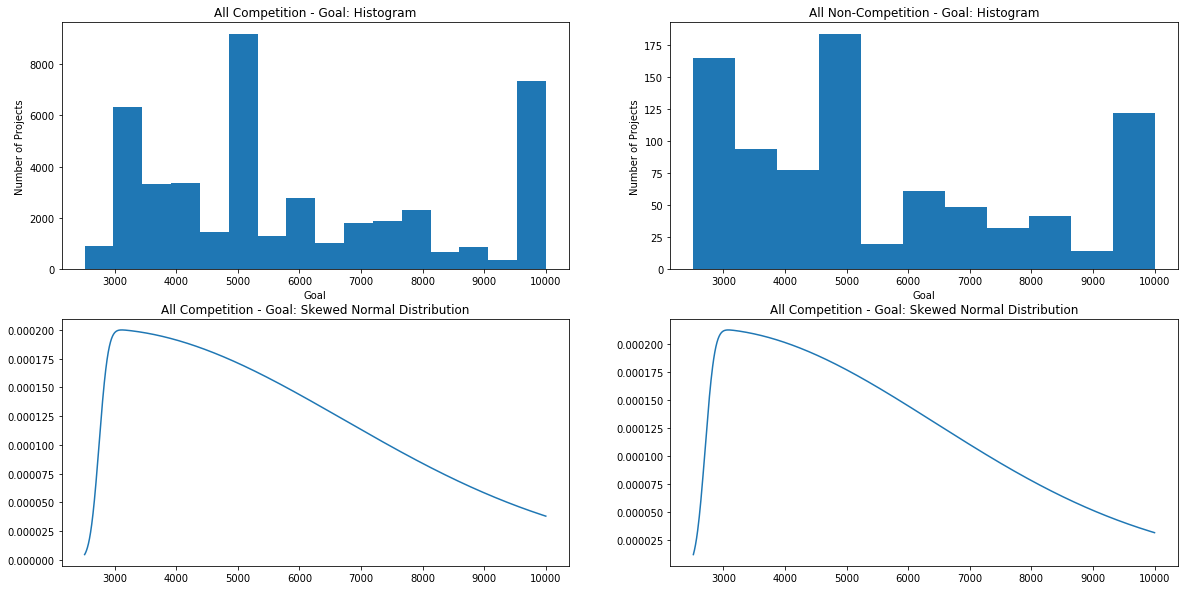

In [156]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3['goal']) if i <= 10000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - Goal: Histogram')
plt.xlabel('Goal')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1['goal']) if i <= 10000]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - Goal: Histogram')
plt.xlabel('Goal')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - Goal: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Competition - Goal: Skewed Normal Distribution')

Text(0.5, 1.0, 'Successful Competition - Goal: Skewed Normal Distribution')

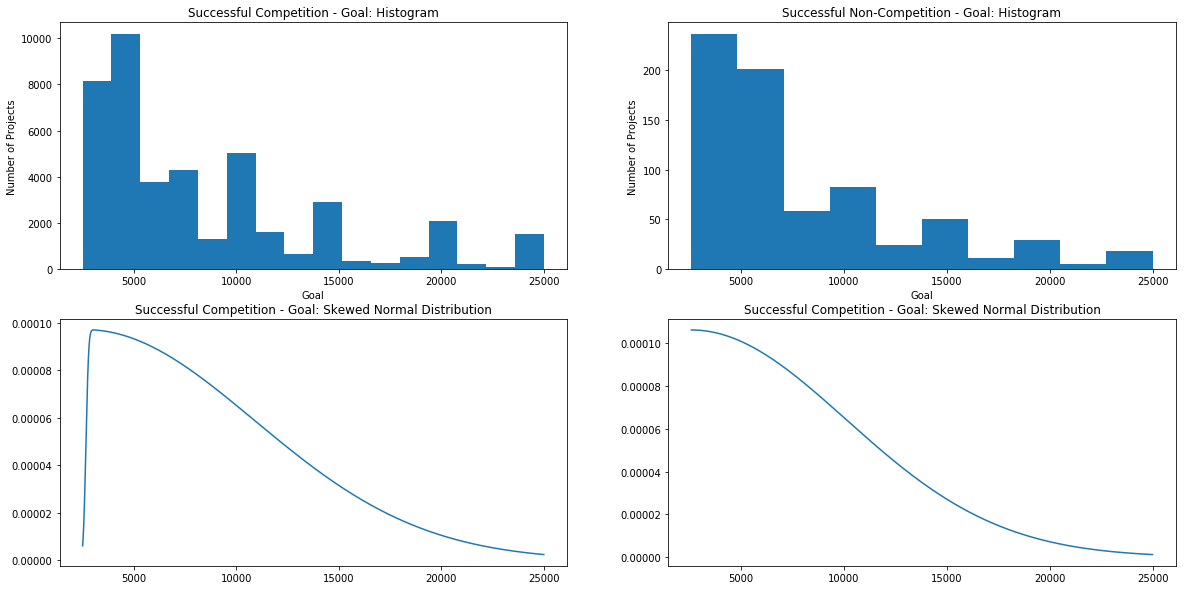

In [159]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3_success['goal']) if i <= 25000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - Goal: Histogram')
plt.xlabel('Goal')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1_success['goal']) if i <= 25000]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - Goal: Histogram')
plt.xlabel('Goal')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - Goal: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Competition - Goal: Skewed Normal Distribution')

Text(0.5, 1.0, 'Non-Failed Competition - Goal: Skewed Normal Distribution')

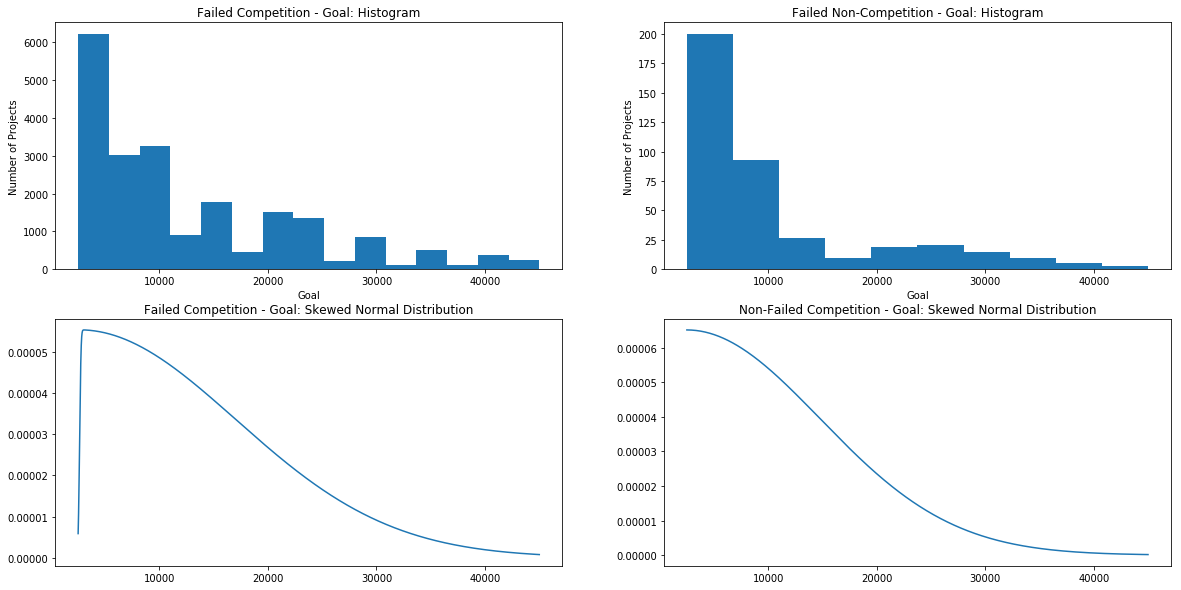

In [153]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3_fail['goal']) if i <= 45000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - Goal: Histogram')
plt.xlabel('Goal')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1_fail['goal']) if i <= 45000]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - Goal: Histogram')
plt.xlabel('Goal')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - Goal: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Non-Failed Competition - Goal: Skewed Normal Distribution')

All competitive vs. non-competitive projects pledged confidence interval
(32721.720350469357, 31273.777493405178, 34169.66320753354)
(23427.074575617284, 19484.15078940551, 27369.998361829057)
(47713.268524612184, 45538.92083852932, 49887.61621069505)
(35930.16611940298, 29746.859680411388, 42113.47255839458)
(3703.2433114519695, 3513.4000074848245, 3893.0866154191144)
(2995.1932723577233, 2173.840962934974, 3816.5455817804727)


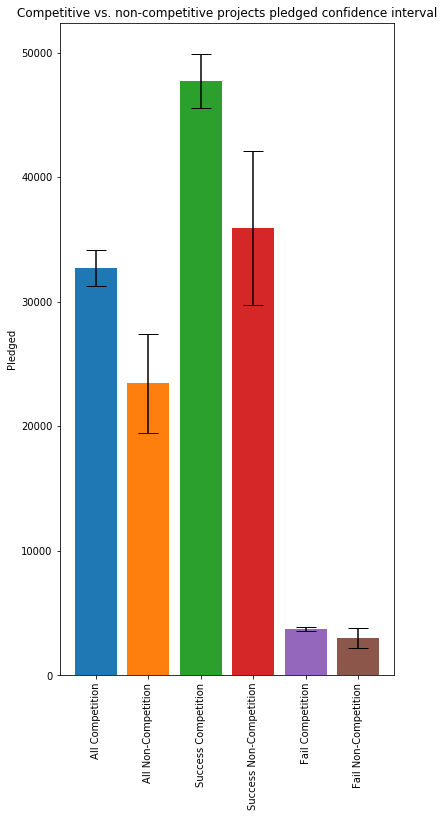

In [289]:
print('All competitive vs. non-competitive projects pledged confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df3['usd_pledged']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df3_1['usd_pledged']), 0.95)

x5, x4, x6 = mean_confidence_interval(list(df3_success['usd_pledged']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df3_1_success['usd_pledged']), 0.95)

x8, x7, x9 = mean_confidence_interval(list(df3_fail['usd_pledged']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df3_1_fail['usd_pledged']), 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects pledged confidence interval')
plt.ylabel('Pledged')
plt.xticks(rotation = 'vertical')
plt.show()

Text(0.5, 1.0, 'All Non-Competition - Pledged: Skewed Normal Distribution')

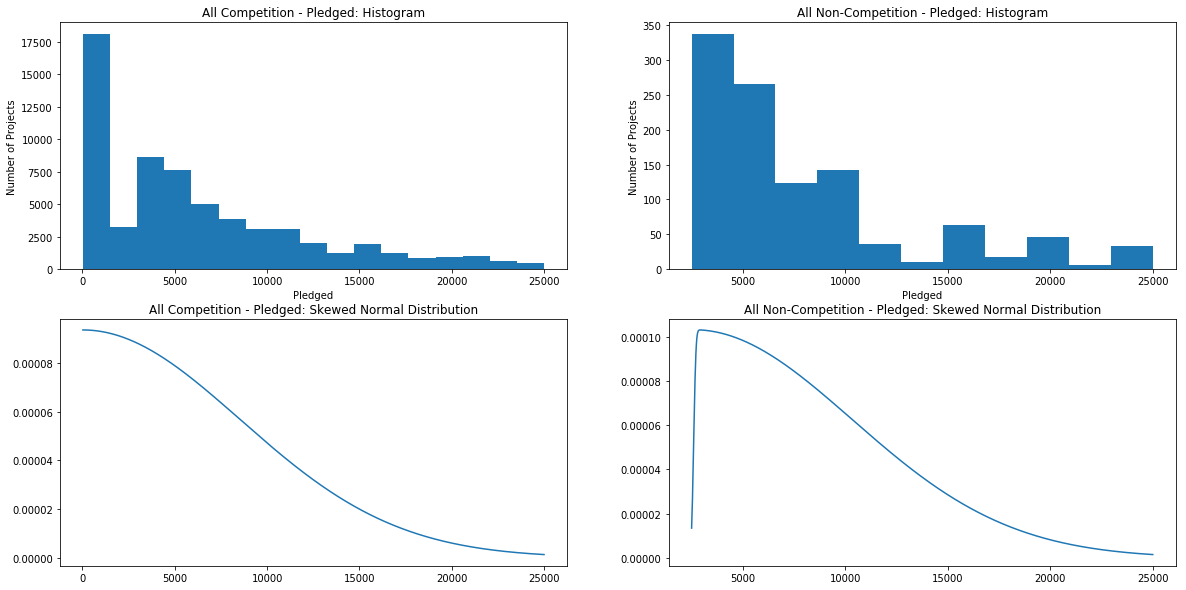

In [219]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3['usd_pledged']) if i <= 25000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - Pledged: Histogram')
plt.xlabel('Pledged')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1['goal']) if i <= 25000]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - Pledged: Histogram')
plt.xlabel('Pledged')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - Pledged: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Non-Competition - Pledged: Skewed Normal Distribution')

Text(0.5, 1.0, 'Successful Non-Competition - Pledged: Skewed Normal Distribution')

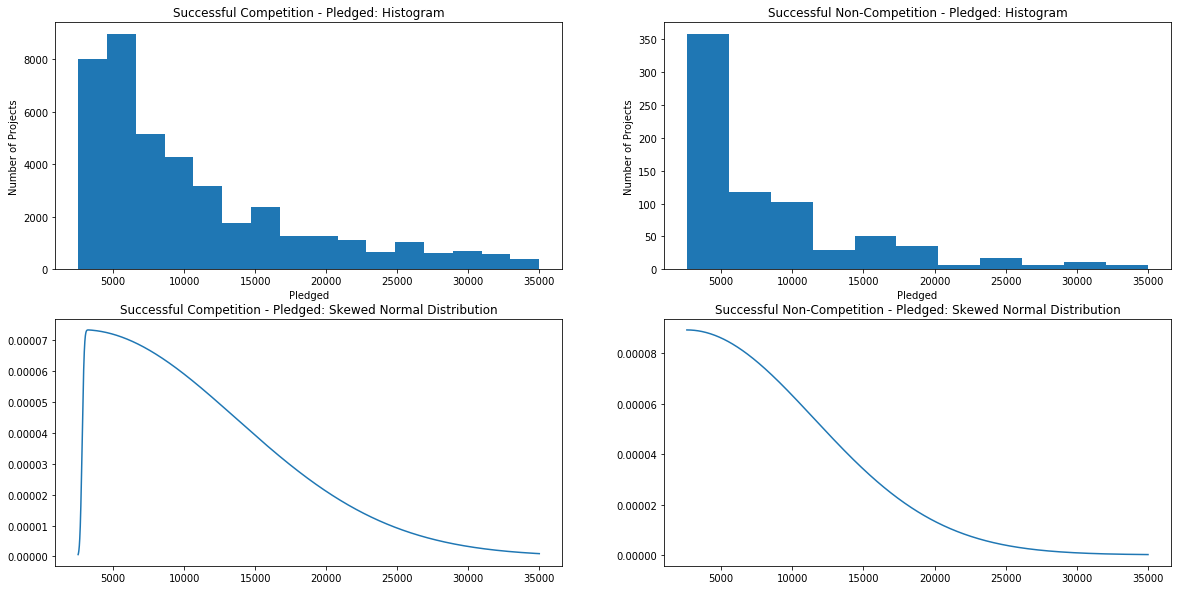

In [222]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3_success['usd_pledged']) if i <= 35000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - Pledged: Histogram')
plt.xlabel('Pledged')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1_success['goal']) if i <= 35000]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - Pledged: Histogram')
plt.xlabel('Pledged')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - Pledged: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Non-Competition - Pledged: Skewed Normal Distribution')

Text(0.5, 1.0, 'Failed Non-Competition - Pledged: Skewed Normal Distribution')

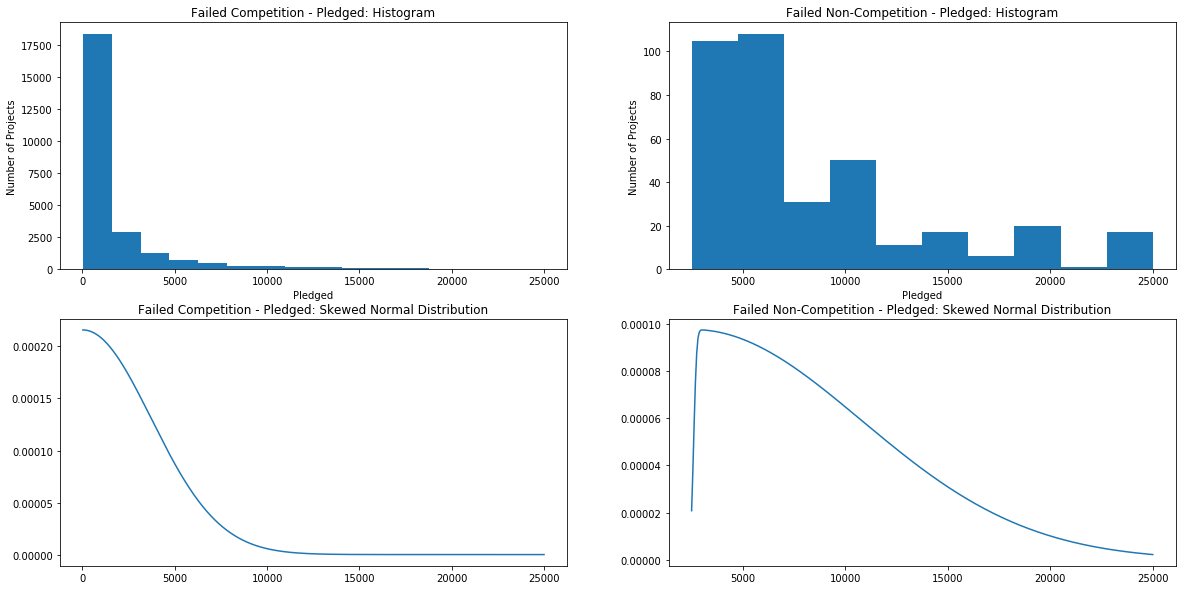

In [223]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3_fail['usd_pledged']) if i <= 25000]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - Pledged: Histogram')
plt.xlabel('Pledged')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1_fail['goal']) if i <= 25000]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - Pledged: Histogram')
plt.xlabel('Pledged')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - Pledged: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Failed Non-Competition - Pledged: Skewed Normal Distribution')

All competitive vs. non-competitive projects backers confidence interval
(356.275726177825, 340.3302314280677, 372.2212209275823)
(265.18364197530866, 226.0032512110457, 304.36403273957166)
(521.3402726479081, 497.38118512950786, 545.2993601663085)
(406.83706467661693, 345.81373899924773, 467.86039035398613)
(36.7675809177174, 35.40253704338157, 38.132624792053235)
(33.701219512195124, 26.81011969107786, 40.59231933331239)


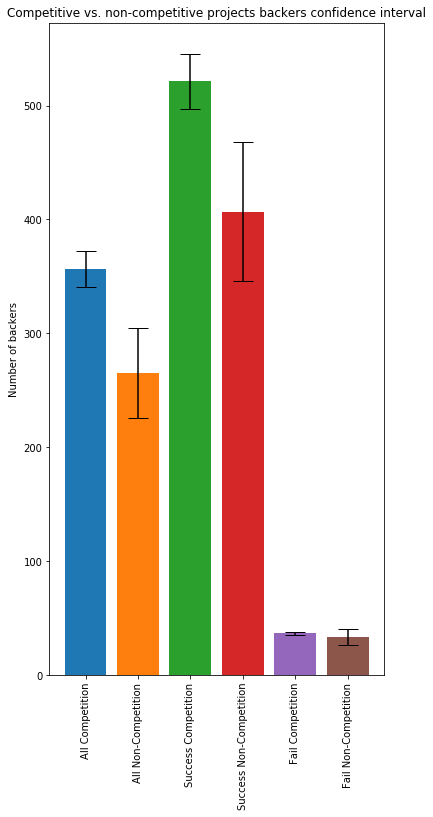

In [288]:
print('All competitive vs. non-competitive projects backers confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df3['backers_count']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df3_1['backers_count']), 0.95)

x5, x4, x6 = mean_confidence_interval(list(df3_success['backers_count']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df3_1_success['backers_count']), 0.95)

x8, x7, x9 = mean_confidence_interval(list(df3_fail['backers_count']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df3_1_fail['backers_count']), 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects backers confidence interval')
plt.ylabel('Number of backers')
plt.xticks(rotation = 'vertical')
plt.show()

Text(0.5, 1.0, 'All Competition - Backers Count: Skewed Normal Distribution')

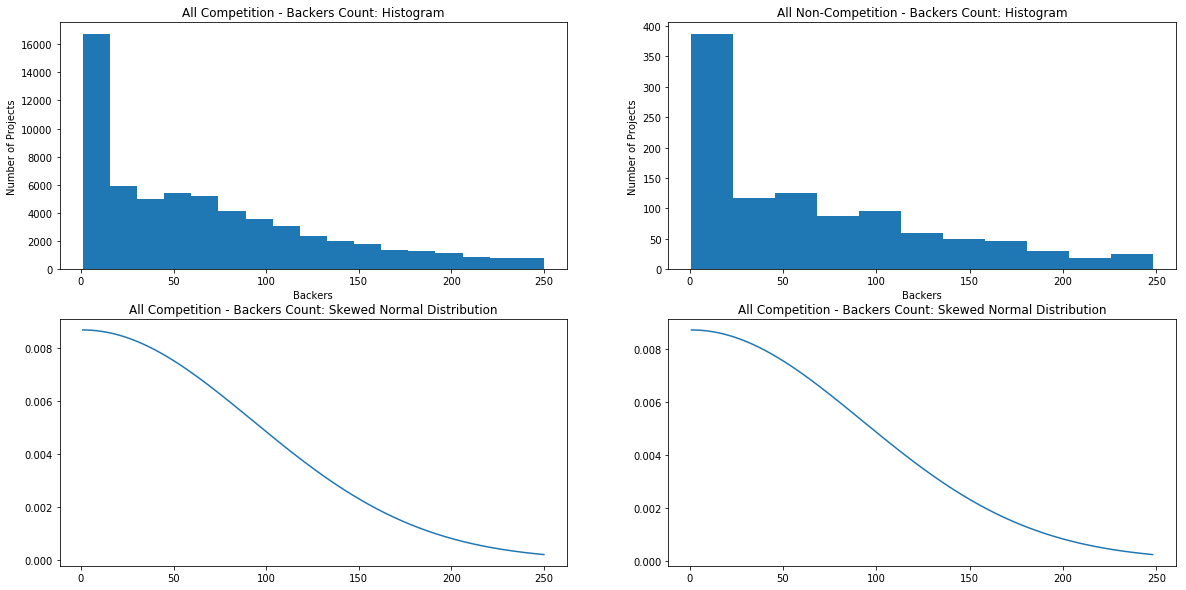

In [173]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3['backers_count']) if i <= 250]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - Backers Count: Histogram')
plt.xlabel('Backers')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1['backers_count']) if i <= 250]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - Backers Count: Histogram')
plt.xlabel('Backers')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - Backers Count: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Competition - Backers Count: Skewed Normal Distribution')

Text(0.5, 1.0, 'Successful Competition - Backers Count: Skewed Normal Distribution')

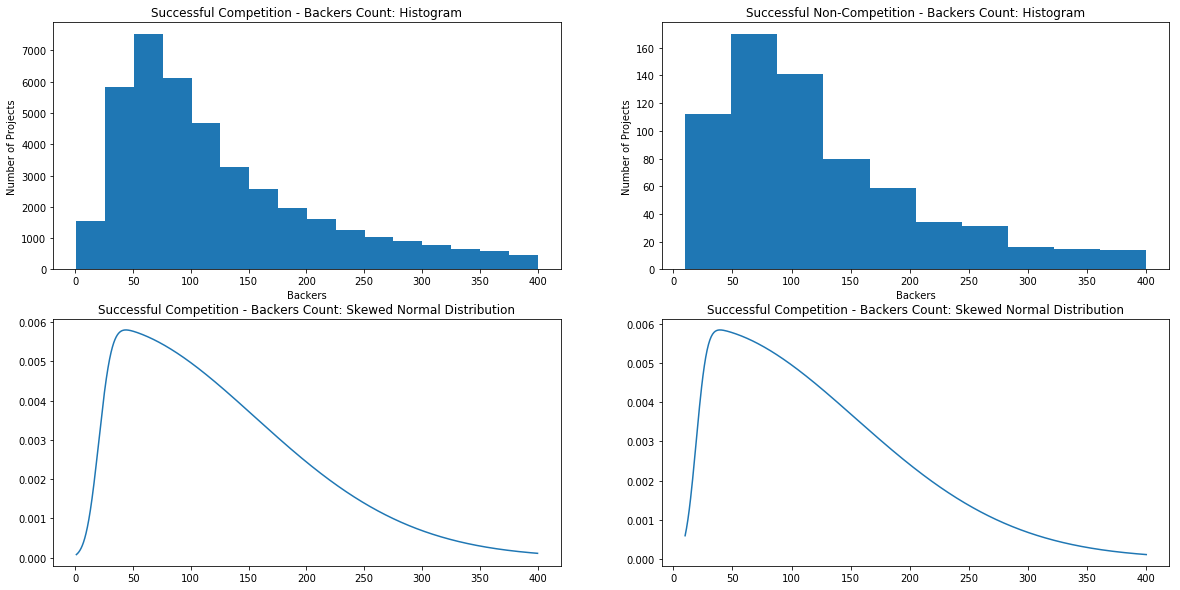

In [174]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3_success['backers_count']) if i <= 400]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - Backers Count: Histogram')
plt.xlabel('Backers')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1_success['backers_count']) if i <= 400]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - Backers Count: Histogram')
plt.xlabel('Backers')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - Backers Count: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Competition - Backers Count: Skewed Normal Distribution')

Text(0.5, 1.0, 'Failed Competition - Backers Count: Skewed Normal Distribution')

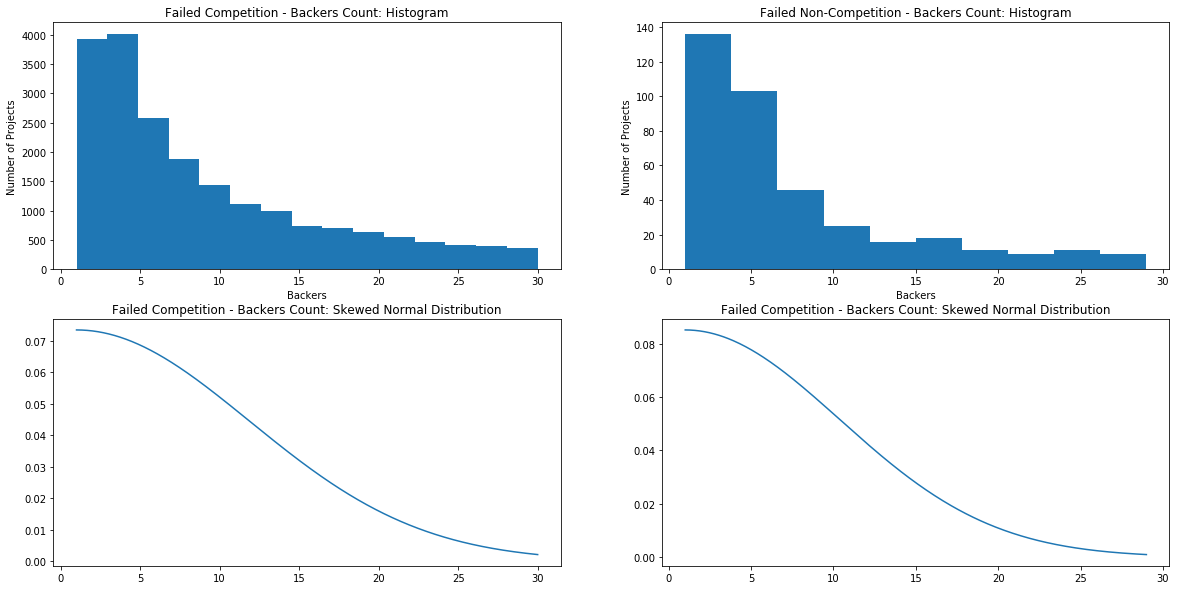

In [224]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3_fail['backers_count']) if i <= 30]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - Backers Count: Histogram')
plt.xlabel('Backers')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1_fail['backers_count']) if i <= 30]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - Backers Count: Histogram')
plt.xlabel('Backers')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - Backers Count: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Failed Competition - Backers Count: Skewed Normal Distribution')

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

All competitive vs. non-competitive projects duration confidence interval
(2.9854135837457947, 2.9548455179440305, 3.015981649547559)
(1.5573252378381206, 1.4896350345298262, 1.625015441146415)
(2.941007679392171, 2.904777655028156, 2.977237703756186)
(1.6952382615861696, 1.616523785731822, 1.7739527374405173)
(3.0698169523537207, 3.0139700124960562, 3.125663892211385)
(1.3101925040077238, 1.1872888408518651, 1.4330961671635825)


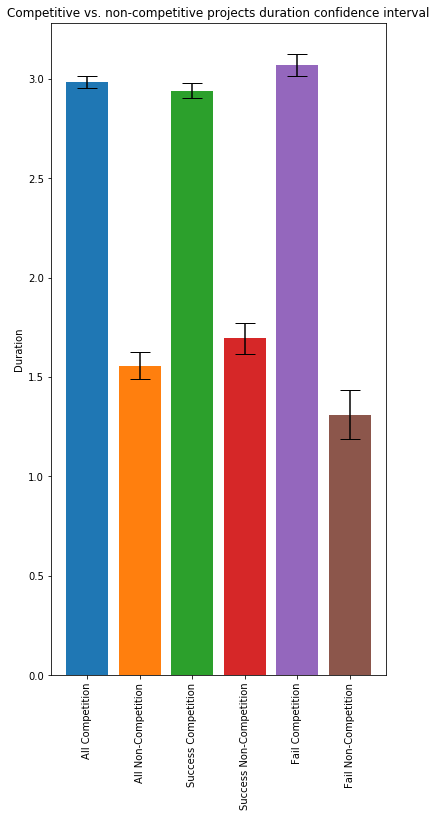

In [180]:
df3['duration'] = (df3['deadline'] - df3['created_at']) / np.timedelta64(1,'M')
df3_1['duration'] = (df3_1['deadline'] - df3_1['created_at']) / np.timedelta64(1,'M')

df3_success['duration'] = (df3_success['deadline'] - df3_success['created_at']) / np.timedelta64(1,'M')
df3_1_success['duration'] = (df3_1_success['deadline'] - df3_1_success['created_at']) / np.timedelta64(1,'M')

df3_fail['duration'] = (df3_fail['deadline'] - df3_fail['created_at']) / np.timedelta64(1,'M')
df3_1_fail['duration'] = (df3_1_fail['deadline'] - df3_1_fail['created_at']) / np.timedelta64(1,'M')

print('All competitive vs. non-competitive projects duration confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df3['duration']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df3_1['duration']), 0.95)

x5, x4, x6 = mean_confidence_interval(list(df3_success['duration']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df3_1_success['duration']), 0.95)

x8, x7, x9 = mean_confidence_interval(list(df3_fail['duration']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df3_1_fail['duration']), 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects duration confidence interval')
plt.ylabel('Duration')
plt.xticks(rotation = 'vertical')
plt.show()

Text(0.5, 1.0, 'All Competition - Duration: Skewed Normal Distribution')

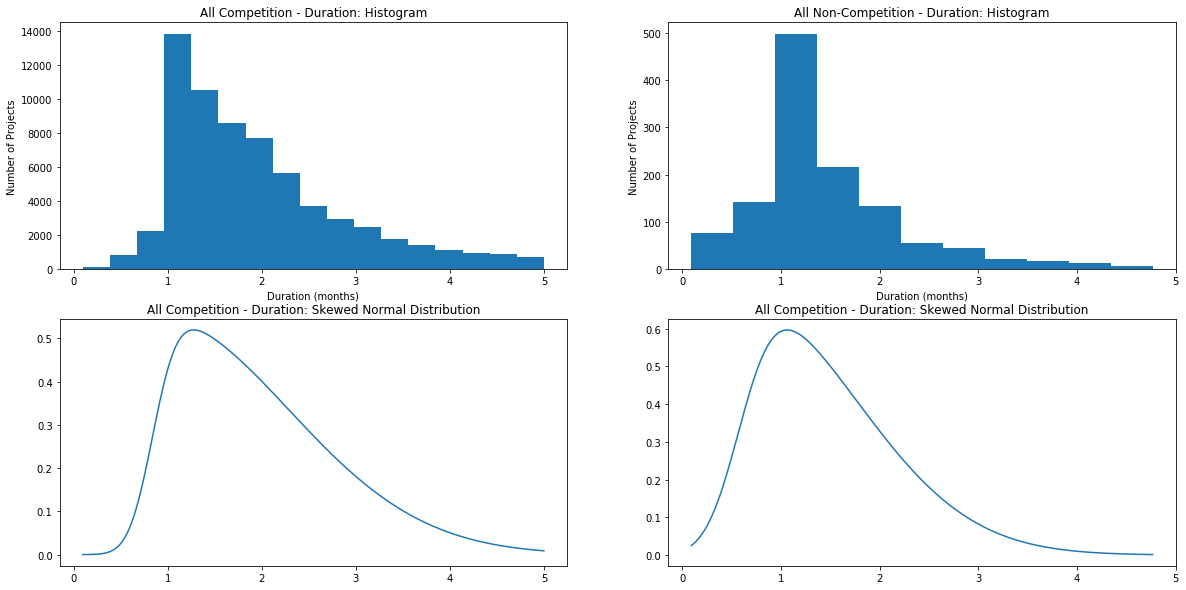

In [227]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3['duration']) if i <= 5]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1['duration']) if i <= 5]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - Duration: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Competition - Duration: Skewed Normal Distribution')

Text(0.5, 1.0, 'Successful Non-Competition - Duration: Skewed Normal Distribution')

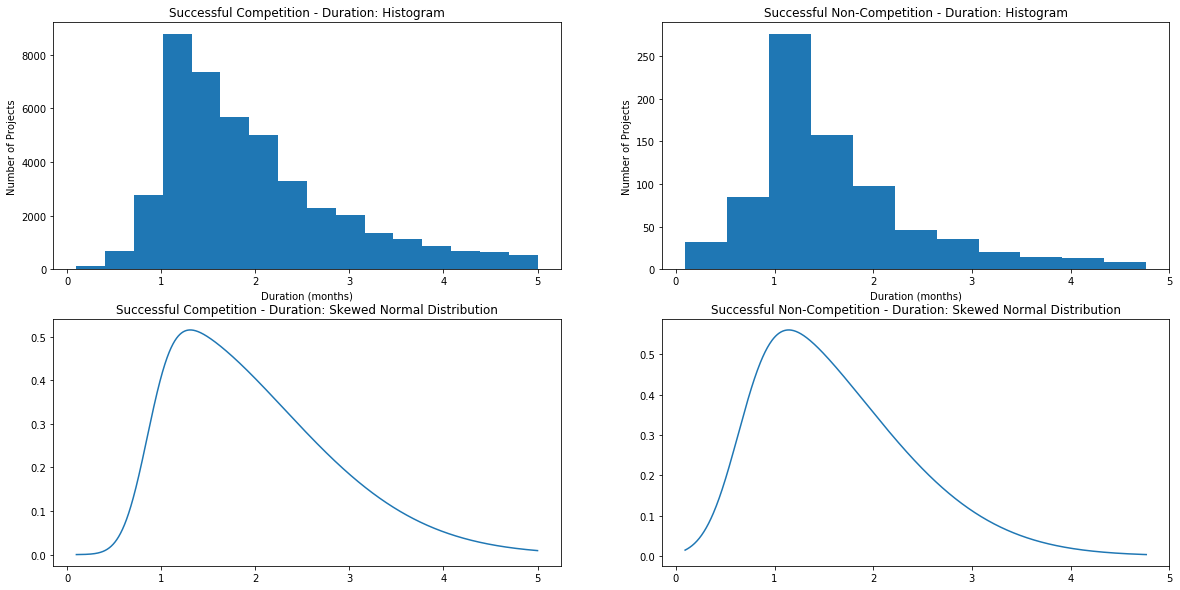

In [225]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3_success['duration']) if i <= 5]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1_success['duration']) if i <= 5]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - Duration: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Non-Competition - Duration: Skewed Normal Distribution')

Text(0.5, 1.0, 'Failed Competition - Duration: Skewed Normal Distribution')

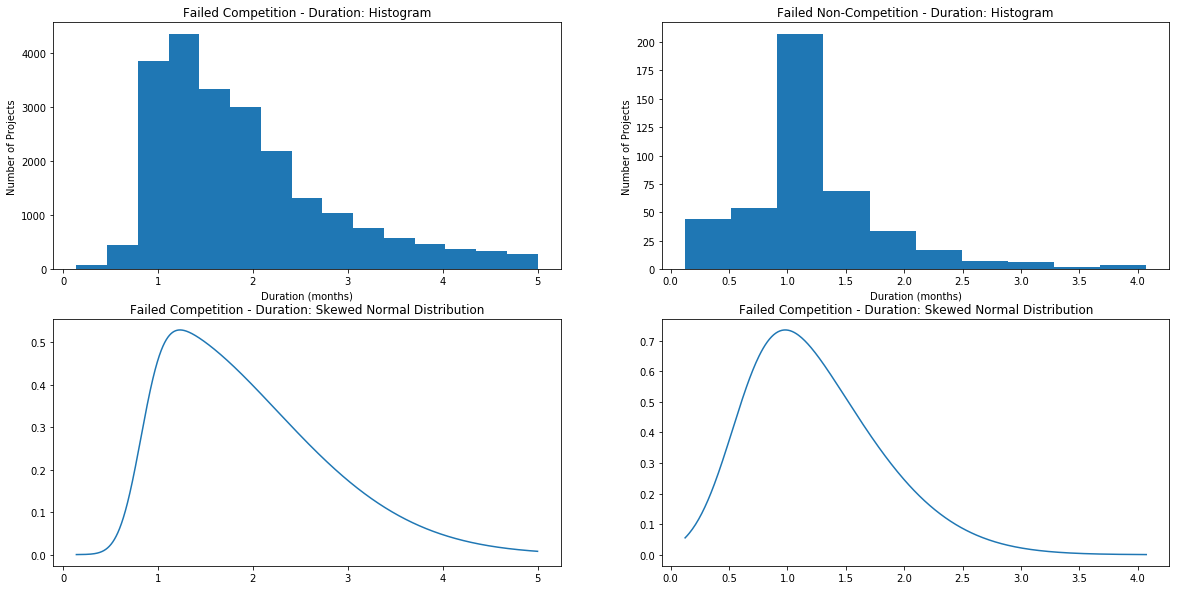

In [226]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in list(df3_fail['duration']) if i <= 5]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df3_1_fail['duration']) if i <= 5]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - Duration: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Failed Competition - Duration: Skewed Normal Distribution')

All competitive vs. non-competitive projects P/G confidence interval
(1.2203627475318097, 1.1999995937412105, 1.240725901322409)
(1.2183433705256685, 1.0430281218423436, 1.3936586192089935)
(1.8016866622547363, 1.771908659157705, 1.8314646653517677)
(1.8429189387025164, 1.5794286009209788, 2.106409276484054)
(0.11542642500521103, 0.11344814002718151, 0.11740470998324054)
(0.09913748661145143, 0.08609099413784077, 0.11218397908506209)


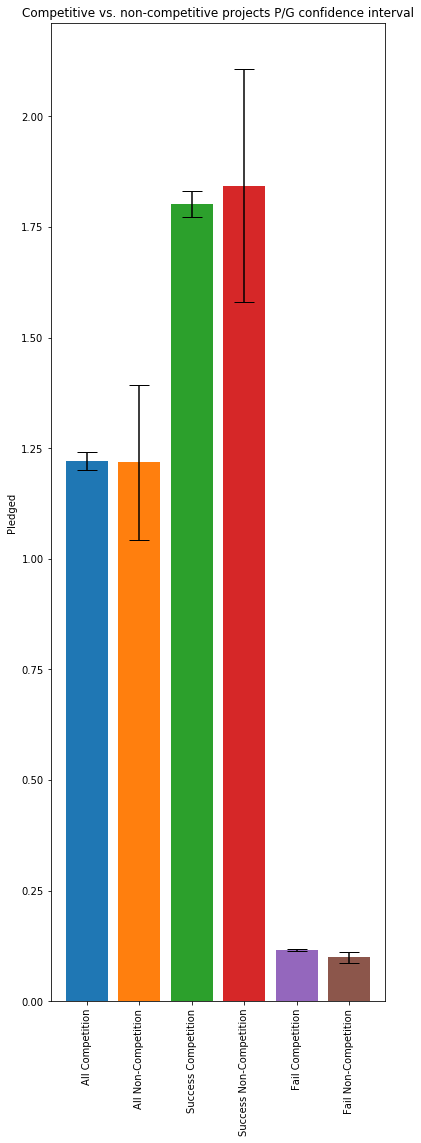

In [190]:
print('All competitive vs. non-competitive projects P/G confidence interval')
pg_lst1 = [x/y for x, y in zip(list(df3['usd_pledged']), list(df3['goal']))]
pg_lst2 = [x/y for x, y in zip(list(df3_1['usd_pledged']), list(df3_1['goal']))]
x2, x1, x3 = mean_confidence_interval(pg_lst1, 0.95)
y2, y1, y3 = mean_confidence_interval(pg_lst2, 0.95)

pg_lst3 = [x/y for x, y in zip(list(df3_success['usd_pledged']), list(df3_success['goal']))]
pg_lst4 = [x/y for x, y in zip(list(df3_1_success['usd_pledged']), list(df3_1_success['goal']))]
x5, x4, x6 = mean_confidence_interval(pg_lst3, 0.95)
y5, y4, y6 = mean_confidence_interval(pg_lst4, 0.95)

pg_lst5 = [x/y for x, y in zip(list(df3_fail['usd_pledged']), list(df3_fail['goal']))]
pg_lst6 = [x/y for x, y in zip(list(df3_1_fail['usd_pledged']), list(df3_1_fail['goal']))]
x8, x7, x9 = mean_confidence_interval(pg_lst5, 0.95)
y8, y7, y9 = mean_confidence_interval(pg_lst6, 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 18))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects P/G confidence interval')
plt.ylabel('Pledged')
plt.xticks(rotation = 'vertical')
plt.show()

Text(0.5, 1.0, 'All Competition - P/G: Skewed Normal Distribution')

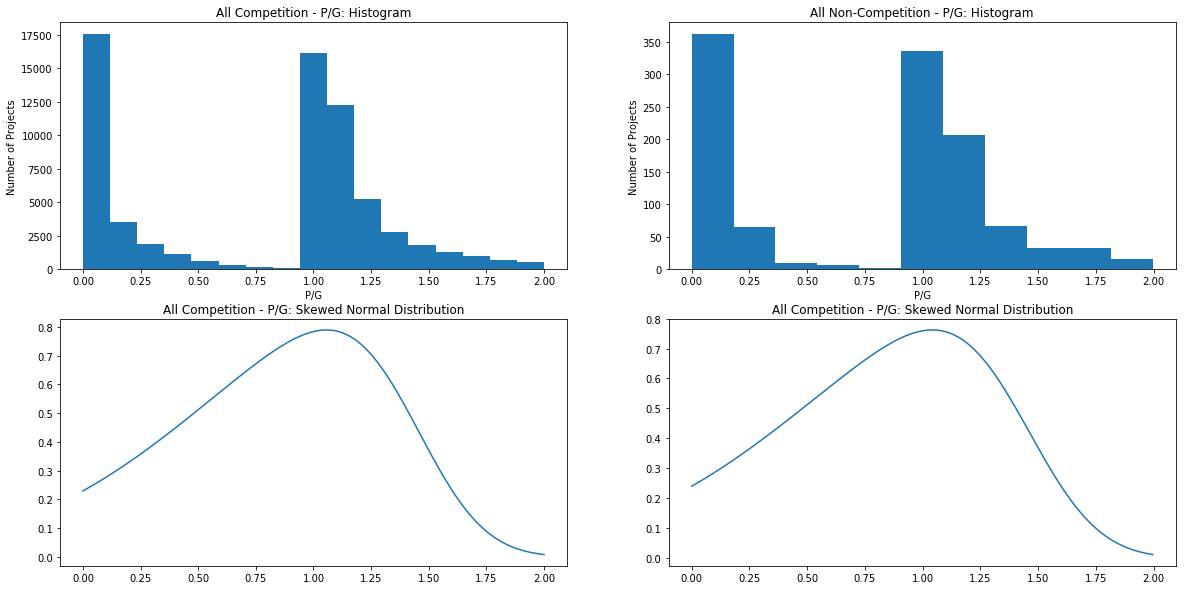

In [202]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in pg_lst1 if i <= 2]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('All Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in pg_lst2 if i <= 2]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('All Non-Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('All Competition - P/G: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('All Competition - P/G: Skewed Normal Distribution')

Text(0.5, 1.0, 'Successful Competition - P/G: Skewed Normal Distribution')

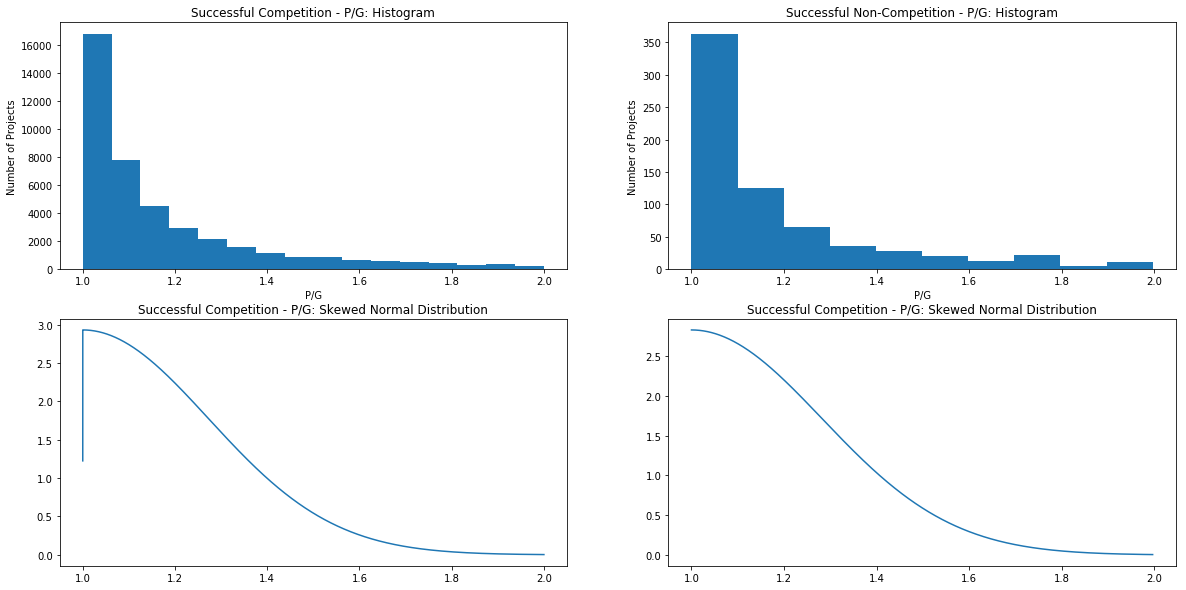

In [203]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in pg_lst3 if i <= 2]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Successful Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in pg_lst4 if i <= 2]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Successful Non-Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Successful Competition - P/G: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Successful Competition - P/G: Skewed Normal Distribution')

Text(0.5, 1.0, 'Failed Competition - P/G: Skewed Normal Distribution')

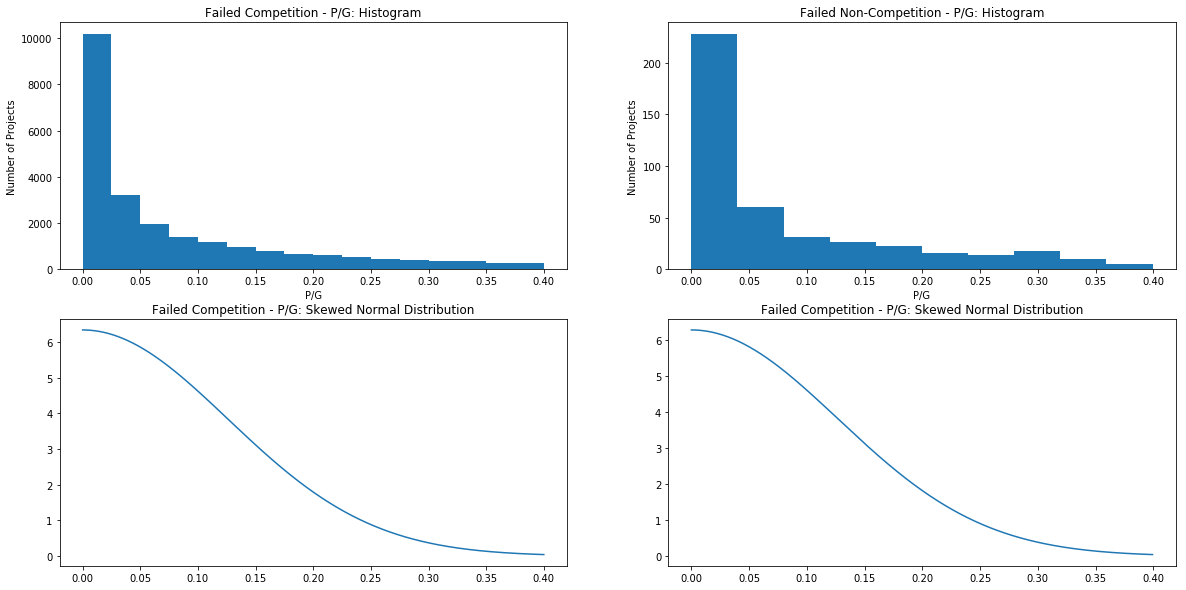

In [207]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
new_lst = [i for i in pg_lst5 if i <= 0.4]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Failed Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in pg_lst6 if i <= 0.4]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Failed Non-Competition - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Failed Competition - P/G: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Failed Competition - P/G: Skewed Normal Distribution')